In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir("/content/drive/My Drive")

Mounted at /content/drive


In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import tensorflow_hub as hub
print(tf.__version__)

2.4.0


In [ ]:
# Authenticate yourself to use the TPUs
import os

IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()

In [ ]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.22.77.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.22.77.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.22.77.58:8470']
Number of accelerators:  8


In [ ]:
CLASS_NAMES =np.array([item for item in ['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']]) 
CLASS_NAMES

array(['afraid', 'angry', 'disgusted', 'happy', 'neutral', 'sad',
       'surprised'], dtype='<U9')

In [ ]:
module_selection = ("mobilenet_v2_100_224", 224) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"resnet_v2_50\", 224)","(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)

BATCH_SIZE = 32*strategy.num_replicas_in_sync
IMG_HEIGHT = pixels
IMG_WIDTH = pixels  
IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)

In [ ]:
train_dir = "/content/drive/MyDrive/Affectnet+100KDEF" 
test_val_dir = "/content/drive/MyDrive/KDEF-100"

In [ ]:
# train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
#                                                                   rotation_range=30,
#                                                                   horizontal_flip=True,
#                                                                   zoom_range=0.05,
#                                                                   zca_whitening=True,
#                                                                   validation_split=0.1)
# train_data_gen=train_image_generator.flow_from_directory(train_dir,
#                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
#                                                    class_mode='categorical',
#                                                    shuffle=True,
#                                                    batch_size=BATCH_SIZE,
#                                                    subset='training',
#                                                    classes=list(CLASS_NAMES)
#                                                    )
# valid_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
#                                                                   rotation_range=30,
#                                                                   horizontal_flip=True,
#                                                                   zoom_range=0.05,
#                                                                   zca_whitening=True,
#                                                                   validation_split=0.99)
# valid_data_gen=image_generator.flow_from_directory(test_val_dir,
#                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
#                                                    class_mode='categorical',
#                                                    shuffle=False,
#                                                    batch_size=BATCH_SIZE,
#                                                    subset='validation',
#                                                    classes=list(CLASS_NAMES)
#                                                    )

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
preprocess_function = tf.keras.applications.mobilenet.preprocess_input #@param ["tf.keras.applications.inception_v3.preprocess_input","tf.keras.applications.resnet.preprocess_input", "tf.keras.applications.mobilenet.preprocess_input"] {type:"raw", allow-input: true}
train_batches = ImageDataGenerator(preprocessing_function= preprocess_function).flow_from_directory(directory=train_dir,target_size=(IMG_HEIGHT,IMG_WIDTH),classes=list(CLASS_NAMES),batch_size=BATCH_SIZE)
valid_batches = ImageDataGenerator(preprocessing_function= preprocess_function).flow_from_directory(directory=test_val_dir,target_size=(IMG_HEIGHT,IMG_WIDTH),classes=list(CLASS_NAMES),batch_size=BATCH_SIZE)

Found 20300 images belonging to 7 classes.
Found 4198 images belonging to 7 classes.


In [ ]:
# import math
# datagen_kwargs = dict(rescale=1./255, validation_split=.99)
# dataflow_kwargs = dict(color_mode="rgb",target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
#                    interpolation="bilinear")

# valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     **datagen_kwargs)
# valid_generator = valid_datagen.flow_from_directory(
#     test_val_dir, subset="validation", shuffle=False, **dataflow_kwargs) #test_val_dir

# do_data_augmentation = True #@param {type:"boolean"}
# if do_data_augmentation:
#   train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#       rotation_range=40,
#       horizontal_flip=True,
#       width_shift_range=0.2, 
#       height_shift_range=0.2,
#       shear_range=0.2, zoom_range=0.2,
#       **datagen_kwargs)
# else:
#   train_datagen = valid_datagen
# train_generator = train_datagen.flow_from_directory(
#     train_dir, subset="training", shuffle=True, **dataflow_kwargs) #train_dir


# number_of_valid_examples = len(valid_generator.filenames)
# number_of_generator_calls = math.ceil(number_of_valid_examples / (1.0 * BATCH_SIZE)) 
# # 1.0 above is to skip integer division

# valid_labels = []

# for i in range(0,int(number_of_generator_calls)):
#     valid_labels.extend(np.array(valid_generator[i][1]))

In [ ]:
STEPS_PER_EPOCH=np.ceil(len(train_batches.filenames)/BATCH_SIZE)
VALIDATION_STEPS=np.ceil(len(valid_batches.filenames)/BATCH_SIZE)
print(STEPS_PER_EPOCH , VALIDATION_STEPS)

80.0 17.0


In [ ]:
#@title Display Utilities (Displaying a batch of images)
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [ ]:
train_img_batch,train_label_batch = next(train_batches) 
test_img_batch,test_label_batch=next(valid_batches)   #Iterating over the Generator

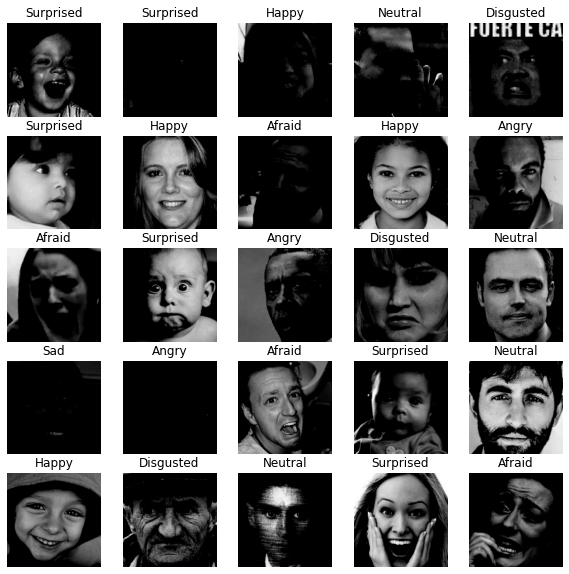

In [ ]:
show_batch(train_img_batch, train_label_batch)

In [ ]:
train_label_batch,test_label_batch=train_label_batch.astype('uint32'),test_label_batch.astype('uint32') 
#To change the dtype of labels as it supports only "uint32" in case of TPU


Using tf.data API for increasing the speed of training

In [ ]:
train_ds=tf.data.Dataset.from_tensor_slices((train_img_batch,train_label_batch))
test_ds=tf.data.Dataset.from_tensor_slices((test_img_batch,test_label_batch))

In [ ]:
train_ds = train_ds.shuffle(1024).repeat().batch(BATCH_SIZE).cache()
test_ds = test_ds.repeat().batch(BATCH_SIZE).cache()

Model Creation

In [ ]:
do_fine_tuning = True #@param {type:"boolean"}

In [ ]:
def create_model():
  print("Building model with", MODULE_HANDLE)
  model = tf.keras.Sequential([
      # Explicitly define the input shape so the model can be properly
      # loaded by the TFLiteConverter
      tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
      hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
      tf.keras.layers.Dropout(rate=0.2),
      tf.keras.layers.Dense(train_ds.num_classes,
                            kernel_regularizer=tf.keras.regularizers.l2(0.0001))
  ])
  model.build((None,)+IMAGE_SIZE+(3,))
  model.summary()
  model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])
  return model
    # model = Sequential([
    #     Conv2D(16,(3,3),activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    #     MaxPool2D(),
    #     Dropout(0.5),
    #     Conv2D(32,(3,3),activation='relu'),
    #     MaxPool2D(),
    #     Dropout(0.4),
    #     Flatten(),
    #     Dense(128,activation='relu'),
    #     Dense(5, activation='softmax')
    # ])
    # model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
   

In [ ]:
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

In [ ]:
# from datetime import datetime
# from tensorflow import keras
# # Clear out prior logging data.
# !rm -rf /content/gdrive/MyDrive/MyCNN/logs/image

# logdir = "/content/drive/MyDrive/MyCNN/logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# # Define the basic TensorBoard callback.
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
# file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

In [ ]:
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# def log_confusion_matrix(epoch, logs):
#   # Use the model to predict the values from the validation dataset.
#   # test_pred_raw = model.predict(x1)
#   # test_pred = np.argmax(test_pred_raw, axis=1)
#   Y_pred = model.predict_generator(valid_data_gen, valid_data_gen.samples // BATCH_SIZE+1)
#   y_pred = np.argmax(Y_pred, axis=1)
#   # Calculate the confusion matrix.
#   # cm = sklearn.metrics.confusion_matrix(valid_labels, test_pred)
#   cm = confusion_matrix(valid_data_gen.classes, y_pred)
#   # Log the confusion matrix as an image summary.
#   figure = plot_confusion_matrix(cm, class_names=list(train_generator.class_indices.keys()))
#   cm_image = plot_to_image(figure)

#   # Log the confusion matrix as an image summary.
#   with file_writer_cm.as_default():
#     tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# # Define the per-epoch callback.
# cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [ ]:
# #Atutomatic rename with epoch number and val accuracy:
# from keras.callbacks import *
# filepath="/content/drive/MyDrive/MyCNN/epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [tensorboard_callback, cm_callback, checkpoint]

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension.
%load_ext tensorboard

Actually train the model. While the first epoch will be quite a bit slower as we must XLA-compile the execution graph and load the data, later epochs should complete in ~35s.

In [ ]:
# Train on TPUs
import time 

# # Start TensorBoard.
# %tensorboard --logdir /content/gdrive/MyDrive/MyCNN/logs/image

with strategy.scope():
    model = create_model()

model.summary()
start = time.time()
model.fit(train_ds,
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_data=test_ds,
          validation_steps=VALIDATION_STEPS,
          # callbacks=callbacks_list,
          epochs=40,
          verbose=2)
print("It took {} seconds".format(time.time() - start))

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4


InvalidArgumentError: ignored

In [ ]:
model.save('Inception-v3-TPU.h5')
model.save("/content/gdrive/MyDrive/MyCNN/Inception-v3-TPU.h5")

In [ ]:
plt.plot(model.history.history['accuracy'], label='accuracy')
plt.plot(model.history.history['loss'],label='loss')
plt.plot(model.history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(model.history.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
# plt.ylim([0,2])
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
# plt.ylim([0,1])
plt.plot(model.history.history["accuracy"])
plt.plot(model.history.history["val_accuracy"])

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Y_pred = model.predict(valid_data_gen, valid_data_gen.samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_data_gen.classes, y_pred)
print(cm)
print('Classification Report')
target_names = list(train_ds.class_indices.keys())
print(classification_report(valid_data_gen.classes, y_pred, target_names=target_names))


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=valid_data_gen.classes)

# make the plot bigger
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)

Predictons

In [ ]:
# If model is provided, use it to generate predictions.
def display_nine_flowers(images, titles, title_colors=None):
  subplot = 331
  plt.figure(figsize=(13,13))
  for i in range(9):
    color = 'black' if title_colors is None else title_colors[i]
    display_one_flower(images[i], titles[i], 331+i, color)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

In [ ]:
def flower_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
  class_idx = np.argmax(label, axis=-1)
  prediction_idx = np.argmax(prediction, axis=-1)
  if class_idx == prediction_idx:
    return f'{CLASSES[prediction_idx]} [correct]', 'black'
  else:
    return f'{CLASSES[prediction_idx]} [incorrect, should be {CLASSES[class_idx]}]', 'red'

def get_titles(images, labels, model):
  predictions = model.predict(images)
  titles, colors = [], []
  for label, prediction in zip(classes, predictions):
    title, color = flower_title(label, prediction)
    titles.append(title)
    colors.append(color)
  return titles, colors
def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()
  
validation_viz_iterator = get_dataset_iterator(valid_data_gen, 9)

In [ ]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, model)
display_nine_flowers(images, titles, colors)